In [2]:
import pandas as pd
import numpy as np
import urllib3

# DISEASE-GENE PAIRS FROM FDA APPROVED DRUGS PAPER
(https://www.nature.com/articles/d41573-022-00120-3)

<br>
Which is the number of rows in the original file? 

In [3]:
pair_disease_ensg = pd.read_csv("./output_vcf/reformatted_excel.tsv", sep="\t")
len(pair_disease_ensg)

50

In [4]:
disgenet_api_output = pd.read_csv("./output_vcf/testing_gdas.tsv", sep="\t")
disgenet_api_output.head()

,inputDiseaseID,disease_name,diseaseID,diseaseType,diseaseVocabularies,pmids,num_pmids,ensemblGeneIDs,geneNcbiID,geneSymbol,score
0,EFO_0000249,"ALZHEIMER DISEASE, EARLY ONSET; ALZHEIMER'S DI...",UMLS_C0494463; UMLS_C0750901; UMLS_C0002395; U...,disease,MONDO_0015140; UMLS_C0494463; MONDO_0011777; M...,None,0,ENSG00000142192,351,APP,0.8; 0.3; 0.9500000000000001; 0.5; 0.300000000...
1,EFO_0003060,CARCINOMA OF LUNG; NON-SMALL CELL LUNG CARCINOMA,UMLS_C0684249; UMLS_C0007131,disease,NCI_C4878; MESH_D002289; EFO_0003060; DO_3905;...,None,0,ENSG00000105976,4233,MET,0.5; 0.9
2,EFO_0002690,"LUPUS ERYTHEMATOSUS, SYSTEMIC",UMLS_C0024141,disease,MESH_D008180; NCI_C3201; MONDO_0007915; DO_907...,None,0,ENSG00000142166,3454,IFNAR1,0.30000000000000004
3,EFO_0000339,"MYELOID LEUKEMIA, CHRONIC; CHRONIC MYELOGENOUS...",UMLS_C0023473; UMLS_C1292771,disease,UMLS_C1292771; ICD10_C92.1; HPO_HP:0005506; IC...,None,0,ENSG00000097007,25,ABL1,0.9500000000000001; 0.5
4,EFO_0000220,ACUTE LYMPHOCYTIC LEUKEMIA; PRECURSOR CELL LYM...,UMLS_C0023448; UMLS_C0023449; UMLS_C1961102,disease,NCI_C7539; ICD10_C91.9; UMLS_C1961102; DO_1037...,None,0,ENSG00000166183,374569,ASPG,0.5; 0.4; 0.2


In [10]:
disgenet_disease_ensg = disgenet_api_output[['inputDiseaseID','ensemblGeneIDs']]

<br>
Which is the number of rows in the output file after querying to DISGENET API?

In [11]:
len(disgenet_disease_ensg)


29

In this file, all rows should be appearing only once, is it the case? **YES**

In [12]:
disgenet_disease_ensg['inputDiseaseID'].sort_values().nunique()

29

With this chunk of code we check that all the rows in the final file coming from DISGENET API are also present in the original file from the paper. Indeed, we see that this condition is accomplished.
<br>
We also see there are two rows that have **None** value in the first column.

In [13]:
found_items = 0
none_ids = 0
parsed_ids = set()

for idx, row in enumerate(pair_disease_ensg.values):
    if row[0] == 'None':
        none_ids += 1
        
    else:
        if row[0] not in parsed_ids and row[0] in disgenet_disease_ensg['inputDiseaseID'].values:
            found_items += 1
            parsed_ids.add(row[0])
        else:
            pass
            
print('Number of rows in the final file from the original file: {}'.format(found_items))
print('Number of rows with ID == None: {}'.format(none_ids))


Number of rows in the final file from the original file: 29
Number of rows with ID == None: 2


<br>
Finally, we create a Dataframe that will store only the IDs that matched with the original file and are not **None**. 
<br>
In this Dataframe there are some rows that will have the DiseaseID repeated but that is because even though the DiseaseIDs are the same, the ENSGs are different.

In [16]:
match_ids = pd.DataFrame()

for idx, row in enumerate(pair_disease_ensg.values):
    if row[0] == 'None':
        continue
    else:
        if row[0] in disgenet_disease_ensg['inputDiseaseID'].values:
            match_ids = match_ids.append(pd.Series(row), ignore_index=True)

            
match_ids.rename(columns={0:'DiseaseID',1:'ENSG_IDs'}, inplace=True)
matches_sorted = match_ids.sort_values(by=['DiseaseID'], ignore_index=True)
matches_sorted.head(10)

,DiseaseID,ENSG_IDs
0,EFO_0000220,ENSG00000166183
1,EFO_0000249,ENSG00000142192
2,EFO_0000270,ENSG00000145777
3,EFO_0000274,ENSG00000169194
4,EFO_0000339,ENSG00000097007
5,EFO_0000401,ENSG00000151623
6,EFO_0000403,ENSG00000177455
7,EFO_0000681,"ENSG00000102755,ENSG00000037280,ENSG00000128052"
8,EFO_0000692,"ENSG00000147246,ENSG00000102468,ENSG0000014929..."
9,EFO_0000702,"ENSG00000135446,ENSG00000105810"


<br>
However, we can check that the number of unique DiseaseIDs is the same as in the final file coming from the DISGENET API: **29**.

In [18]:
matches_sorted['DiseaseID'].nunique()

29

# HEATMAP OF THE SCORES FOR EACH DISEASE-GENE ASSOCIATION

Previosuly, we just created a dataframe with the information of diseaseIDs and their corresponding ENSG_IDs to visualize which of these pairs appeared also in DISGENET PLUS.

Now, we want to break down all these combinations into single diseaseID-ENSG_ID pairs, with their corresponding score returned by DISGENET PLUS to create a heatmap of them afterwards.

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

In [25]:
disgenet_api_with_scores = pd.read_csv("./output_vcf/testing_gdas_singlepairs.tsv", sep="\t") 

In [26]:
disgenet_api_subset =  disgenet_api_with_scores[['inputDiseaseID','ensemblGeneIDs','score', 'geneSymbol', 'disease_name']]
disgenet_api_subset

,inputDiseaseID,ensemblGeneIDs,score,geneSymbol,disease_name
0,EFO_0000249,ENSG00000142192,0.95,APP,ALZHEIMER'S DISEASE
1,EFO_0000249,ENSG00000142192,0.95,APP,ALZHEIMER'S DISEASE
2,EFO_0000249,ENSG00000142192,0.95,APP,ALZHEIMER'S DISEASE
3,EFO_0000249,ENSG00000142192,0.95,APP,ALZHEIMER'S DISEASE
4,EFO_0000249,ENSG00000142192,0.95,APP,ALZHEIMER'S DISEASE
5,EFO_0003060,ENSG00000105976,0.9,MET,CARCINOMA OF LUNG
6,EFO_0003060,ENSG00000105976,0.9,MET,CARCINOMA OF LUNG
7,EFO_0003060,ENSG00000105976,0.9; 0.5,MET,CARCINOMA OF LUNG; NON-SMALL CELL LUNG CARCINOMA
8,EFO_0003060,ENSG00000105976,0.5,MET,NON-SMALL CELL LUNG CARCINOMA
9,EFO_0003060,ENSG00000105976,0.5,MET,NON-SMALL CELL LUNG CARCINOMA


<br>
Now we separate rows which have more than one score value into several rows, and we keep only the ones with the max score value (only when there are several rows with the same information except for the score value).

In [27]:
new_row = set()
rows_to_append = set()

for disease, ensg, scores, gene_symbol, disease_name in disgenet_api_subset.values:

    if ';' in scores:
        split_scores_list = scores.split(';')
        split_scores_list_floats = [ float(c_score.strip()) for c_score in split_scores_list ]
        rows_to_append.add((disease, disease_name, ensg, gene_symbol, max(split_scores_list_floats)))
            
    else:
        c_score = float(scores)
        rows_to_append.add((disease, disease_name, ensg, gene_symbol, c_score))
    
df = pd.DataFrame(rows_to_append, columns=['disease', 'disease_name', 'ensg', 'geneSymbol', 'score']) 
df_sorted = df.sort_values(by="disease_name").reset_index(drop=True)
df_sorted.head()

,disease,disease_name,ensg,geneSymbol,score
0,ORDO_15,ACHONDROPLASIA,ENSG00000159899,NPR2,0.20
1,EFO_0000220,ACUTE LYMPHOCYTIC LEUKEMIA,ENSG00000166183,ASPG,0.50
2,EFO_0000249,ALZHEIMER'S DISEASE,ENSG00000142192,APP,0.95
3,EFO_0000270,ASTHMA,ENSG00000145777,TSLP,0.40
4,EFO_0003888,ATTENTION DEFICIT HYPERACTIVITY DISORDER,ENSG00000142319,SLC6A3,0.50


In [29]:
cut_names = []

for name in df_sorted['disease_name']:
    if len(str(name)) > 50:
        name = name[:40] + '...'
        cut_names.append(name)
    else:
        cut_names.append(name)

cut_names_series = pd.Series(cut_names) 
df_sorted['cut_disease_names'] = cut_names_series


<br>
Before creating a heatmap we need the data in a wide format so it can be passed to the heatmap seaborn function. And after that we create the heatmap.

In [30]:
df_wide = df_sorted.pivot_table(index='cut_disease_names', columns='geneSymbol', values='score') # conversion to pivot_table as it is necessary for the heatmap creation
df_wide.fillna(0, inplace=True)
df_wide.head()

geneSymbol,ABL1,ANGPTL3,APP,ASPG,CALCRL,CD19,CDK6,DMD,DRD2,DRD3,...,OPRK1,PCSK9,PDCD1,PIK3CD,S1PR1,SLC10A2,SLC6A2,SLC6A3,TSLP,TUBB4B
cut_disease_names,,,,,,,,,,,,,,,,,,,,,
ACHONDROPLASIA,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ACUTE LYMPHOCYTIC LEUKEMIA,0.0,0.0,0.00,0.5,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ALZHEIMER'S DISEASE,0.0,0.0,0.95,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ASTHMA,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.4,0.0
ATTENTION DEFICIT HYPERACTIVITY DISORDER,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0


<br>
Eventually we create the heatmap from our data, and we set some parameters so it can be interpreted more easily.

Text(0.5, 1.0, 'Disease-Gene scores heatmap')

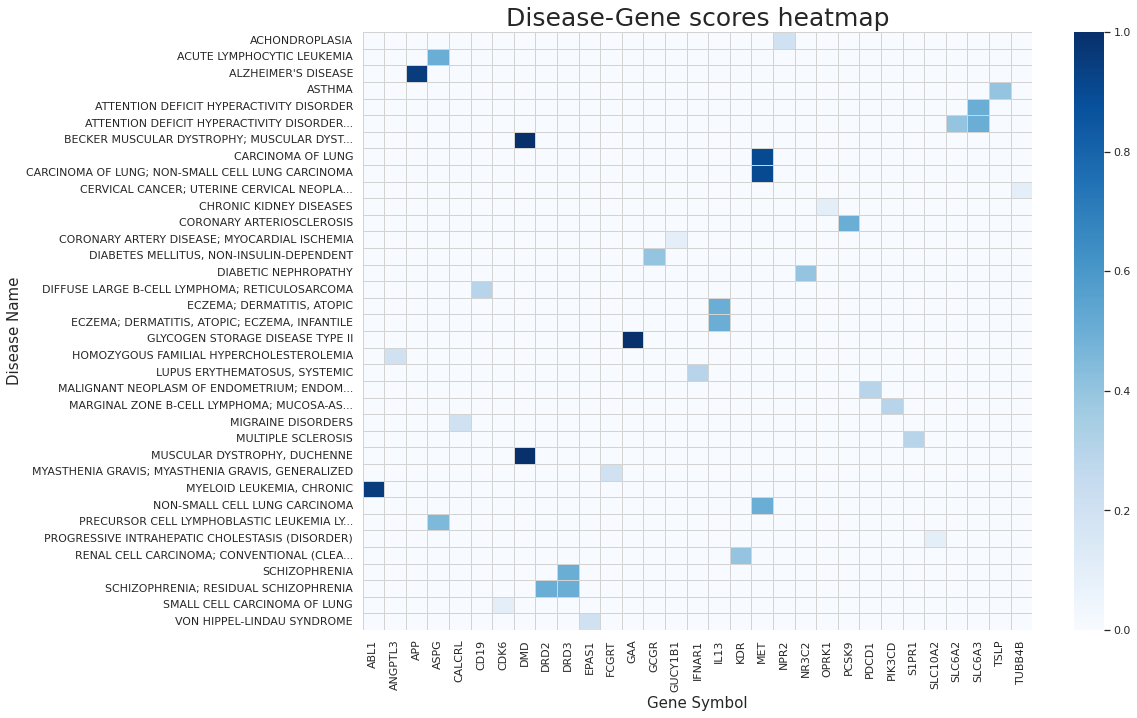

In [32]:
sns.set(rc={'figure.figsize':(15,11)})
fig = sns.heatmap(df_wide, cmap="Blues", linecolor='lightgray', linewidths=0.5) # heatmap without cell labels
fig.set_xlabel("Gene Symbol", size=15)
fig.set_ylabel("Disease Name", size=15)
fig.set_title("Disease-Gene scores heatmap", size = 25)